# Load pretrained model

In [1]:
experiment_name= "C2S_resnet34_semi_hard_margin_1"

In [2]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import datasets
import networks
import utils

In [3]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

'''
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ,
                              transforms.Normalize(mean, std)
                              ])
''' 

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

#######################################################
#                  Create Train Dataset
#######################################################
dataset_train = datasets.DeepFashionDataset(img_dir="./images",train_path="DeepFashionDataset_train.csv",mode="train", transform= transform)
#triplet_dataset_train = datasets.TripletDeepFashion(dataset_train, mode="train")

#train_dataset = datasets.CarsDataset(transform, train=True)

#######################################################
#                  Create Valid Dataset
#######################################################
dataset_valid = datasets.DeepFashionDataset(img_dir="./images",validation_path="DeepFashionDataset_validation.csv",mode="validation", transform= transform)
#triplet_dataset_valid = datasets.TripletDeepFashion(dataset_valid, mode="validation")

#######################################################
#                  Create Test Dataset
#######################################################
dataset_test = datasets.DeepFashionDataset(img_dir="./images",test_path="DeepFashionDataset_test.csv",mode="test", transform= transform)
#triplet_dataset_test = datasets.TripletDeepFashion(dataset_test, mode="test")

In [5]:
len(dataset_train.classes_set)

17968

In [13]:
batch_size= 4
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

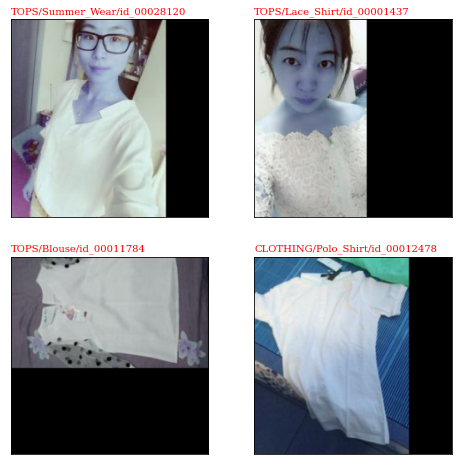

In [14]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_loader.dataset.classes_set[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')

In [8]:
images.shape

(4, 3, 224, 224)

In [9]:
labels

tensor([12643,  6166, 10473, 12619])

In [12]:
len(dataset_test.classes_set)

2258

In [15]:
print([dataset_train.classes_set[i.item()] for i in labels ])

['TOPS/Summer_Wear/id_00028120', 'TOPS/Lace_Shirt/id_00001437', 'TOPS/Blouse/id_00011784', 'CLOTHING/Polo_Shirt/id_00012478']


In [16]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Create the same model:

In [17]:
# Load the pretrained model from pytorch
model= torchvision.models.resnet34(pretrained=True)

# print out the model structure
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
model.fc= nn.Sequential(nn.Linear(512, 256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(256, 256), # embedding size 256
                                )

In [22]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Load the trained model:

In [23]:
PATH= experiment_name+'75epoch.pt'

check_point= torch.load(PATH)
model.load_state_dict(check_point['model_state_dict'])
epoch = check_point['epoch']
loss_val = check_point['loss']

optimizer.load_state_dict(check_point['optimizer_state_dict'])


In [24]:
device = torch.device('cuda')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Calculate Recall on the train dataset:

In [30]:
import torch
from torch.utils.data.sampler import SequentialSampler
import torch.nn.functional as F

def feature(dataset, model):
    Fvecs = []
    dataLoader = torch.utils.data.DataLoader(dataset, batch_size=400, sampler=SequentialSampler(dataset))
    torch.set_grad_enabled(False)
    model.eval()
    for data, target in dataLoader:
        #inputs_bt, labels_bt = data # <FloatTensor> <LongTensor>
        #fvec = model(inputs_bt.cuda())
        
        # data.shape: [400, 3, 224, 224]; target.shape: [400] 
        
        if cuda:
            data = data.to(device)
        
        fvec = model(data) # fvec.shape: [400, 128]

        fvec = F.normalize(fvec, p = 2, dim = 1).cpu() 
        # F.normalize:  performs L2 normalization (p=2) over each row vector (dim=1) 
        # by first calculating the norm of each vector to find max norm; then divides each vector to this max norm.
        # Also known as Euclidean norm
        
        Fvecs.append(fvec)
        
    return torch.cat(Fvecs,0) # Concatenates the given sequence of seq tensors in the given dimension.

In [31]:
def feature_label(dataset, model):
    Fvecs = []
    Labels= []
    dataLoader = torch.utils.data.DataLoader(dataset, batch_size=400, sampler=SequentialSampler(dataset))
    torch.set_grad_enabled(False)
    
    model.eval()
    for data, target in dataLoader:
        #inputs_bt, labels_bt = data # <FloatTensor> <LongTensor>
        #fvec = model(inputs_bt.cuda())
        
        # data.shape: [400, 3, 224, 224]; target.shape: [400] 
        
        if cuda:
            data = data.to(device)
        
        fvec = model(data) # fvec.shape: [400, 128]

        fvec = F.normalize(fvec, p = 2, dim = 1).cpu() 
        # F.normalize:  performs L2 normalization (p=2) over each row vector (dim=1) 
        # by first calculating the norm of each vector to find max norm; then divides each vector to this max norm.
        # Also known as Euclidean norm
        
        Fvecs.append(fvec)
        Labels.append(target)
        
    return torch.cat(Fvecs,0), torch.cat(Labels,0)  # Concatenates the given sequence of seq tensors in the given dimension.

In [32]:
Fvectors = feature(dataset_train, model)

/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [33]:
len(Fvectors)

159062

In [34]:
Fvectors.shape

torch.Size([159062, 256])

In [35]:
def recall(Fvec, imgLab,rank=None):
    # for each row in 

    # imgLab numpy.ndarray of shape: (8041,)
   
    N = len(imgLab) #8041 labels

    imgLab = torch.LongTensor([imgLab[i] for i in range(len(imgLab))])
    # imgLab.shape: [8041]
    # Fvec.shape: [8041, 128]
    
    D = Fvec.mm(torch.t(Fvec)) # mm: matrix multiplication. (n×m) mm (m×p) results in  (n×p) tensor.
    # [8041, 128] mm [128, 8041] --> [8041, 8041] this is D matrix
    # There are 1's along the diagonal!
    
    D[torch.eye(len(imgLab)).bool()] = -1 
    # torch.eye: Returns a 2-D tensor with ones on the diagonal and zeros elsewhere.
    # D[torch.eye(len(imgLab)).bool()]: diagonal elements of D will take a value of -1 ; the rest will remain the same
    
    if rank==None: # only rank 1 is computed
        _,idx = D.max(1) # returns both values and indices; dim=1 means returns for each row 
        imgPre = imgLab[idx]
        A = (imgPre==imgLab).float()
        return (torch.sum(A)/N).item()
    else:
        _,idx = D.topk(rank[-1])
        acc_list = []
        for r in rank:
            A = 0
            for i in range(r):
                imgPre = imgLab[idx[:,i]]
                A += (imgPre==imgLab).float()
            acc_list.append((torch.sum((A>0).float())/N).item())
        return torch.Tensor(acc_list)

In [ ]:
recall(Fvectors, dataset_train.labels, rank= [1, 2, 4, 8, 10, 100]) 

In [ ]:
recall(Fvectors, dataset_train.labels) # recall@1 equals to accuracy

In [ ]:
X, y= feature_label(dataset_train, model)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X, y)

In [ ]:
def read_img(image_path):
    image = load_img(image_path,target_size=(256,256,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [ ]:
import random

In [ ]:
for _ in range(10):
    i = random.randint(1,len(val))
    img1 = read_img(val.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(val.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')

* https://www.kaggle.com/code/quadeer15sh/visually-similar-product-recommendation/notebook
* https://www.kaggle.com/code/jonathanoheix/product-recommendation-based-on-visual-similarity/notebook
* https://www.kaggle.com/code/vikashrajluhaniwal/building-visual-similarity-based-recommendation
* 